# Kuka

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### Start the Environment


Make sure that you're in the right virtual environment and the right python version.

In [ ]:
!python --version
!pip install pybullet
!pip install tensorboardX

Python 3.10.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import sys
from collections import deque, namedtuple
import timeit
from datetime import timedelta
from copy import deepcopy
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import functools
import multiprocessing as mp
from multiprocessing import Pipe
from multiprocessing import Process
import signal
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Normal

from gym import spaces
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import pybullet as p

current_dir=/usr/local/lib/python3.10/dist-packages/pybullet_envs/bullet


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])
def worker(remote, env_fn):
    # Ignore CTRL+C in the worker process
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    env = env_fn()
    try:
        while True:
            cmd, data = remote.recv()
            if cmd == 'step':
                ob, reward, done, info = env.step(data)
                remote.send((ob, reward, done, info))
            elif cmd == 'get_screen':
                screen = env._get_observation()
                screen = env._get_observation().transpose((2, 0, 1))
                screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
                screen = torch.from_numpy(screen)
                screen = resize(screen).unsqueeze(0)
                remote.send(screen)
            elif cmd == 'reset':
                ob = env.reset()
                remote.send(ob)
            elif cmd == 'close':
                remote.close()
                break
            elif cmd == 'get_spaces':
                remote.send((env.action_space, env.observation_space))
            else:
                raise NotImplementedError
    finally:
        env.close()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])
class MultiprocessVectorEnv:
    def __init__(self, env_fns):
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = \
            [Process(target=worker, args=(work_remote, env_fn))
             for (work_remote, env_fn) in zip(self.work_remotes, env_fns)]
        for p in self.ps:
            p.start()
        self.last_obs = [None] * self.num_envs
        self.remotes[0].send(('get_spaces', None))
        self.action_space, self.observation_space = self.remotes[0].recv()
        self.closed = False

    def __del__(self):
        if not self.closed:
            self.close()


    def step(self, actions):
        self._assert_not_closed()
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        results = [remote.recv() for remote in self.remotes]
        self.last_obs, rews, dones, infos = zip(*results)
        return self.last_obs, rews, dones, infos

    def get_screen(self):
        for remote in self.remotes:
            remote.send(('get_screen', None))
        results = [remote.recv() for remote in self.remotes]
        screens = torch.cat(results,dim=0)
        return screens

    def reset(self, mask=None):
        self._assert_not_closed()
        if mask is None:
            mask = np.zeros(self.num_envs)
        for m, remote in zip(mask, self.remotes):
            if not m:
                remote.send(('reset', None))

        obs = [remote.recv() if not m else o for m, remote,
               o in zip(mask, self.remotes, self.last_obs)]
        self.last_obs = obs
        return obs

    def close(self):
        self._assert_not_closed()
        self.closed = True
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()

    @property
    def num_envs(self):
        return len(self.remotes)

    def _assert_not_closed(self):
        assert not self.closed, "This env is already closed"

In [ ]:
def make_env(idx, test):
    env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, removeHeightHack=False, maxSteps=20)
    env.observation_space = spaces.Box(low=0., high=1., shape=(84, 84, 3), dtype=np.float32)
    env.action_space = spaces.Box(low=-1, high=1, shape=(5,1))
    return env

def make_batch_env(test):
    return MultiprocessVectorEnv(
        [functools.partial(make_env, idx, test)
            for idx in range(mp.cpu_count()*2)])

In [ ]:
envs = make_batch_env(test=False)

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Actor-Critic implementation

In [ ]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_path = os.path.join(ckpt_dir, name)

        self.fc1 = nn.Linear(*(np.array(self.state_dims) + np.array(self.action_dims)), self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        state_action = T.cat([state, action], dim=1).to(self.device)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.name = name
        self.ckpt_path = os.path.join(ckpt_dir, name)
        self.reparam_noise = reparam_noise

        self.fc1 = nn.Linear(*state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, *self.action_dims)
        self.sigma = nn.Linear(self.fc2_dims, *self.action_dims)

        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = T.clamp(sigma, min=self.reparam_noise, max=1.)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        probs = Normal(mu, sigma)
        if reparameterize:
            actions = probs.rsample()
        else:
            actions = probs.sample()
        action = T.tanh(actions) * T.tensor(self.max_action).to(self.device)
        log_probs = probs.log_prob(actions)
        log_probs -= T.log(1 - action.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)
        return action, log_probs

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_path = os.path.join(ckpt_dir, self.name)

        self.fc1 = nn.Linear(*self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Init buffer
        self.states = np.zeros((self.buffer_size, *state_dims), dtype=np.float32)
        self.states_ = np.zeros((self.buffer_size, *state_dims), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, *action_dims), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, ), dtype=np.float32)
        self.done = np.zeros((self.buffer_size,), dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.states_[self.ptr] = state_
        self.done[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.buffer_size

        if self.ptr == 0 and not self.is_full:
            self.is_full = True
            print('... Replay Buffer is full ...')

    def load_batch(self, batch_size):
        if self.is_full:
            samples = np.random.choice(np.arange(self.buffer_size), batch_size, replace=False)
        else:
            samples = np.random.choice(np.arange(self.ptr), batch_size, replace=False)
        states = self.states[samples]
        actions = self.actions[samples]
        rewards = self.rewards[samples]
        states_ = self.states_[samples]
        done = self.done[samples]

        return states, actions, rewards, states_, done

In [ ]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.update_period = update_period
        self.tau = tau
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        # init replay buffer
        self.replay_buffer = ReplayBuffer(self.memory_size, self.state_dims, self.action_dims)

        # init actor network
        self.actor = Actor(self.alpha, self.state_dims, self.action_dims, self.fc1_dim, self.fc2_dim, self.max_action,
                           self.reparam_noise_lim, name='Actor', ckpt_dir=self.ckpt_dir)

        # init critic networks
        self.critic_1 = Critic(self.beta, self.state_dims, self.action_dims, self.fc1_dim, self.fc2_dim,
                               name='Critic_1', ckpt_dir=self.ckpt_dir)
        self.critic_2 = Critic(self.beta, self.state_dims, self.action_dims, self.fc1_dim, self.fc2_dim,
                               name='Critic_2', ckpt_dir=self.ckpt_dir)

        # init value network
        self.value = Value(self.beta, self.state_dims, self.fc1_dim, self.fc2_dim,
                           name='Value', ckpt_dir=self.ckpt_dir)

        # init target value network
        self.target_value = Value(self.beta, self.state_dims, self.fc1_dim, self.fc2_dim,
                                  name='Target_Value', ckpt_dir=self.ckpt_dir)

        # hard network parameters update
        self.update_parameters(tau=1)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        state = T.tensor([state], dtype=T.float).to(self.actor.device)
        if deterministic:
            # deterministic action defined by the mean
            mu, _ = self.actor.forward(state)
            actions = mu
        else:
            # stochastic action is sampled from the normal distribution
            actions, _ = self.actor.sample_normal(state, reparameterize)
        return actions.cpu().detach().numpy()[0]

    def store_transition(self, state, action, reward, state_, done):
        return self.replay_buffer.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        states, actions, rewards, states_, done = self.replay_buffer.load_batch(self.batch_size)
        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        done = T.tensor(done, dtype=T.bool).to(self.actor.device)
        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        # update the target value network parameters
        if tau is None:
            tau = self.tau
        value_state_parameters = self.value.named_parameters()
        target_value_state_parameters = self.target_value.named_parameters()

        value_state_dict = dict(value_state_parameters)
        target_value_state_dict = dict(target_value_state_parameters)

        for item in value_state_dict:
            value_state_dict[item] = tau * value_state_dict[item].clone() + \
                                     (1 - tau) * target_value_state_dict[item].clone()

        self.target_value.load_state_dict(value_state_dict)

    def save_model(self):
        # saving all networks
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        # loading all networks
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        # learns only after warmup iteration and when there is at least a single batch in buffer to load
        if self.learn_iter < self.warmup or self.learn_iter < self.batch_size:
            self.learn_iter += 1
            return

        states, actions, rewards, states_, done = self.load_batch()

        # optimize the value network
        actions_, log_probs = self.actor.sample_normal(states, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(states, actions_)
        q2_new_policy = self.critic_2.forward(states, actions_)
        q_min = T.min(q1_new_policy, q2_new_policy).to(self.value.device)
        q_min = q_min.view(-1)
        v = self.value.forward(states).view(-1)
        v_ = self.target_value.forward(states_).view(-1)
        v_[done] = 0.0

        target_value = q_min - log_probs
        value_loss = 0.5 * F.mse_loss(v, target_value)
        self.value.optimizer.zero_grad()
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        # optimize the actor network
        actions_, log_probs = self.actor.sample_normal(states, reparameterize=True)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(states, actions_)
        q2_new_policy = self.critic_2.forward(states, actions_)
        q_min = T.min(q1_new_policy, q2_new_policy).to(self.value.device)
        q_min = q_min.view(-1)

        self.actor.optimizer.zero_grad()
        actor_loss = T.mean(log_probs - q_min)
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        # optimize the critic networks
        q_ = self.reward_scale * rewards.view(-1) + self.gamma * v_
        q1_old_policy = self.critic_1.forward(states, actions).view(-1)
        q2_old_policy = self.critic_2.forward(states, actions).view(-1)
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_)
        critic_loss = T.add(critic_1_loss, critic_2_loss)
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        # soft update networks parameters
        if self.learn_iter % self.update_period == 0:
            self.update_parameters()
        self.learn_iter += 1

Examine the state and action spaces.

Number of agents: 24
Size of each action: 5


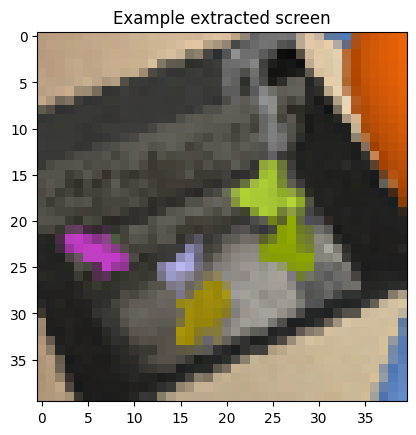

In [ ]:
envs.reset()

# number of agents
num_agents = envs.num_envs
print('Number of agents:', num_agents)

init_screen = envs.get_screen().to(device)
_, _, screen_height, screen_width = init_screen.shape

# size of each action
action_size = envs.action_space.shape[0]
print('Size of each action:', action_size)

plt.figure()
plt.imshow(init_screen[0].cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    #env.render(mode='human')
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)
def eval_policy(envs, policy, tmax=1000):
    reward_list=[]
    state = envs.reset()
    for t in range(tmax):
        states = get_screen()
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        _, reward, done, _  = envs.step(actions[0])
        dones = done
        reward_list.append(np.mean(reward))

        # stop if any of the trajectories is done to have retangular lists
        if np.any(dones):
            break
    return reward_list

## Network Architecture
An actor-critic structure with continuous action space is used for this project. The policy consists of 3 parts, a shared hidden layers, actor, and critic.
The actor layer outputs the mean value of a normal distribution, from which the agent's action is sampled. The critic layer yields the value function.

- Shared layer:
```
Input State(48,48,3) -> Conv2d(3, 16, 5, 2) -> BatchNorm2d(16) -> Conv2d(16, 32, 5, 2)-> BatchNorm2d(32)
-> Conv2d(32, 32, 5, 2) -> BatchNorm2d(32) -> Dense(128) -> LeakyReLU -> Dense(128) -> LeakyReLU -> Dense(64) -> LeakyReLU
```
- Actor and Critic layers:
```
LeakyRelu -> Dense(64) -> LeakyRelu -> Dense(4)-> tanh -> Actor's output
LeakyReLU -> Dense(64) -> LeakyRelu -> Dense(1) -> Critic's output
```

### Model update using PPO/GAE
The hyperparameters used during training are:

Parameter | Value | Description
------------ | ------------- | -------------
Number of Agents | 1 | Number of agents trained simultaneously
tmax | 20 | Maximum number of steps per episode
Epochs | 10 | Number of training epoch per batch sampling
Batch size | 128 | Size of batch taken from the accumulated  trajectories
Discount (gamma) | 0.993 | Discount rate
Epsilon | 0.07 | Ratio used to clip r = new_probs/old_probs during training
Gradient clip | 10.0 | Maximum gradient norm
Beta | 0.01 | Entropy coefficient
Tau | 0.95 | tau coefficient in GAE
Learning rate | 2e-4 | Learning rate
Optimizer | Adam | Optimization method


In [ ]:
# Define hyperparameters
state_size = screen_height * screen_width * 3  # Assuming RGB images
action_size = envs.action_space.shape[0]
hidden_layers = [128, 64]
lr = 3e-4
gamma = 0.99
tau = 0.005
alpha = 0.2
batch_size = 256
buffer_size = 1000000

# Initialize SAC policy
policy = SACActorCritic(
    state_size=state_size,
    action_size=action_size,
    hidden_layers=hidden_layers,
    init_type='xavier-uniform',
    seed=0
).to(device)

# Initialize target entropy
policy.target_entropy = -torch.prod(torch.Tensor(envs.action_space.shape).to(device)).item()

# Create separate optimizers for actor, critic, and alpha
actor_optimizer = optim.Adam(policy.actor.parameters(), lr=lr)
critic_optimizer = optim.Adam(list(policy.critic1.parameters()) + list(policy.critic2.parameters()), lr=lr)
alpha_optimizer = optim.Adam([policy.log_alpha], lr=lr)

# Initialize replay buffer
memory = ReplayBuffer(buffer_size)

In [ ]:
PATH = 'policy_sac.pt'

In [ ]:
# Hyperparameters (using previously defined values)
writer = SummaryWriter()

total_steps = 0
episode_reward = 0
state = envs.reset()
save_scores = []
scores_window = deque(maxlen=100)  # last 100 scores
start_time = timeit.default_timer()
best_mean_reward = None
season = 1000000
tmax = 1000//num_agents   #env episode steps

for s in range(season):
    for step in range(tmax):
        state_tensor = torch.FloatTensor(state).reshape(1, -1).to(device)  # Flatten the state
        action, _ = policy.sample(state_tensor)
        action = action.cpu().detach().numpy()[0]

        next_state, reward, done, _ = envs.step(action)
        memory.push(state.flatten(), action, reward, next_state.flatten(), done)

        state = next_state
        episode_reward += reward
        total_steps += 1

        if len(memory) > batch_size:
            update_sac(policy, critic_optimizer, actor_optimizer, alpha_optimizer, memory, batch_size, gamma, tau, device)

        if done:
            state = envs.reset()
            scores_window.append(episode_reward)
            save_scores.append(episode_reward)
            writer.add_scalar("Episode Reward", episode_reward, total_steps)
            episode_reward = 0

    # Evaluate after each season
    mean_reward = np.mean(scores_window)
    writer.add_scalar("Mean Reward (100 episodes)", mean_reward, s)

    if best_mean_reward is None or best_mean_reward < mean_reward:
        torch.save({
            'policy_state_dict': policy.state_dict(),
            'critic_optimizer_state_dict': critic_optimizer.state_dict(),
            'actor_optimizer_state_dict': actor_optimizer.state_dict(),
            'alpha_optimizer_state_dict': alpha_optimizer.state_dict()
        }, PATH)
        if best_mean_reward is not None:
            print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_reward:.3f}, model saved")
        best_mean_reward = mean_reward

    if mean_reward > 50:
        print(f'Environment solved in {s+1} seasons!\tAverage Score: {mean_reward:.2f}')
        break

print(f'Average Score: {mean_reward:.2f}')
elapsed = timeit.default_timer() - start_time
print(f"Elapsed time: {timedelta(seconds=elapsed)}")
writer.close()
envs.close()

<ipython-input-28-7cb274f04177>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state_tensor = torch.FloatTensor(state).reshape(1, -1).to(device)  # Flatten the state


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x165888 and 4800x128)

In [ ]:
fig = plt.figure()
plt.plot(np.arange(len(save_scores)), save_scores)
plt.ylabel('Score')
plt.xlabel('Season #')
plt.grid()
plt.show()

In [ ]:
def plot_training_progress(scores, epsilons, betas, losses, value_mses, episode_lengths):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    axs[0, 0].plot(scores)
    axs[0, 0].set_title('Score per Episode')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Score')

    axs[0, 1].plot(epsilons, label='Epsilon')
    axs[0, 1].plot(betas, label='Beta')
    axs[0, 1].set_title('Epsilon and Beta Decay')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].legend()

    axs[1, 0].plot(losses)
    axs[1, 0].set_title('Total Loss')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Loss')

    axs[1, 1].plot(value_mses)
    axs[1, 1].set_title('Value Function MSE')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('MSE')

    axs[2, 0].plot(episode_lengths)
    axs[2, 0].set_title('Mean Episode Length')
    axs[2, 0].set_xlabel('Episode')
    axs[2, 0].set_ylabel('Length')

    plt.tight_layout()
    plt.show()

## Evaluation

In [ ]:
episode = 10
scores_window = deque(maxlen=100)  # last 100 scores
env = KukaDiverseObjectEnv(renders=False, isDiscrete=False, removeHeightHack=False, maxSteps=20, isTest=True)
env.cid = p.connect(p.DIRECT)
# load the model
checkpoint = torch.load(PATH)
policy.load_state_dict(checkpoint['policy_state_dict'])

# evaluate the model
for e in range(episode):
    rewards = eval_policy(envs=env, policy=policy)
    reward = np.sum(rewards,0)
    print("Episode: {0:d}, reward: {1}".format(e+1, reward), end="\n")

In [ ]:
# After training, call the function with your collected data
plot_training_progress(save_scores, epsilons, betas, losses, value_mses, episode_lengths)